In [ ]:
# poc: 
# file: 
# date created:
# last update:

### Imports

In [63]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Data Ingest

In [2]:
df = pd.read_csv('./data/data_sunspots.csv')
df.columns = ['Date', 'Sunspots']
df['Date'] = pd.to_datetime(df['Date'])

print(df.shape)
print(df.columns)
display(df.head(3))
display(df.tail(3))

(3252, 2)
Index(['Date', 'Sunspots'], dtype='object')


,Date,Sunspots
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7


,Date,Sunspots
3249,2019-10-31,0.4
3250,2019-11-30,0.5
3251,2019-12-31,1.6


The dataset starts in January 1749 and stretches to December 2019, 3251 measurements over 271 years. 

### Basic Visualization

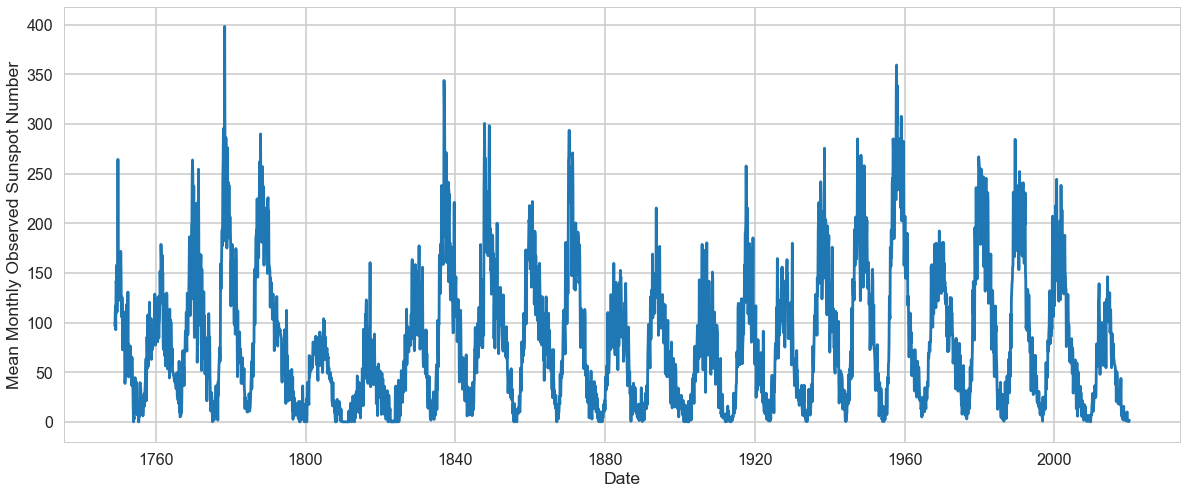

In [3]:
plt.figure(figsize=(20,8))
plt.style.use('seaborn-poster')
plt.style.use('seaborn-whitegrid')
plt.plot(df['Date'], df['Sunspots']); 
plt.xlabel('Date');
plt.ylabel('Mean Monthly Observed Sunspot Number');

### Regression Dataset Creation

We use a useful function definition from Jason Brownlee (https://machinelearningmastery.com/) to transform the time series sunspot data into a dataset that a machine learning regression model can be trained on.

In [4]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
df_data = series_to_supervised(df['Sunspots'].to_list(), 100, 1) # 500 # 20
df_data.head(3)

,var1(t-100),var1(t-99),var1(t-98),var1(t-97),var1(t-96),var1(t-95),var1(t-94),var1(t-93),var1(t-92),var1(t-91),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
100,96.7,104.3,116.7,92.8,141.7,139.2,158.0,110.5,126.5,125.8,...,10.7,19.7,23.8,28.3,15.7,23.5,35.3,43.7,50.0,63.5
101,104.3,116.7,92.8,141.7,139.2,158.0,110.5,126.5,125.8,264.3,...,19.7,23.8,28.3,15.7,23.5,35.3,43.7,50.0,63.5,21.3
102,116.7,92.8,141.7,139.2,158.0,110.5,126.5,125.8,264.3,142.0,...,23.8,28.3,15.7,23.5,35.3,43.7,50.0,63.5,21.3,41.7


In [8]:
df_X = df_data[df_data.columns[:-1]]
df_y = df_data[df_data.columns[-1]]

print(df_X.shape, df_y.shape)

(3152, 100) (3152,)


In [9]:
X = df_X.values
y = df_y.values

In [11]:
#round(X.shape[0]*fraction_test)

In [12]:
# don't use this for time sequence !
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 

# use this for time sequence!
fraction_test = 0.33
X_train = X[:round(X.shape[0]*(1-fraction_test)), ]
y_train = y[:round(y.shape[0]*(1-fraction_test)), ]
X_test = X[round(X.shape[0]*(1-fraction_test)):, ]
y_test = y[round(y.shape[0]*(1-fraction_test)):, ]

print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(3152, 100) (2112, 100) (1040, 100)
(3152,) (2112,) (1040,)


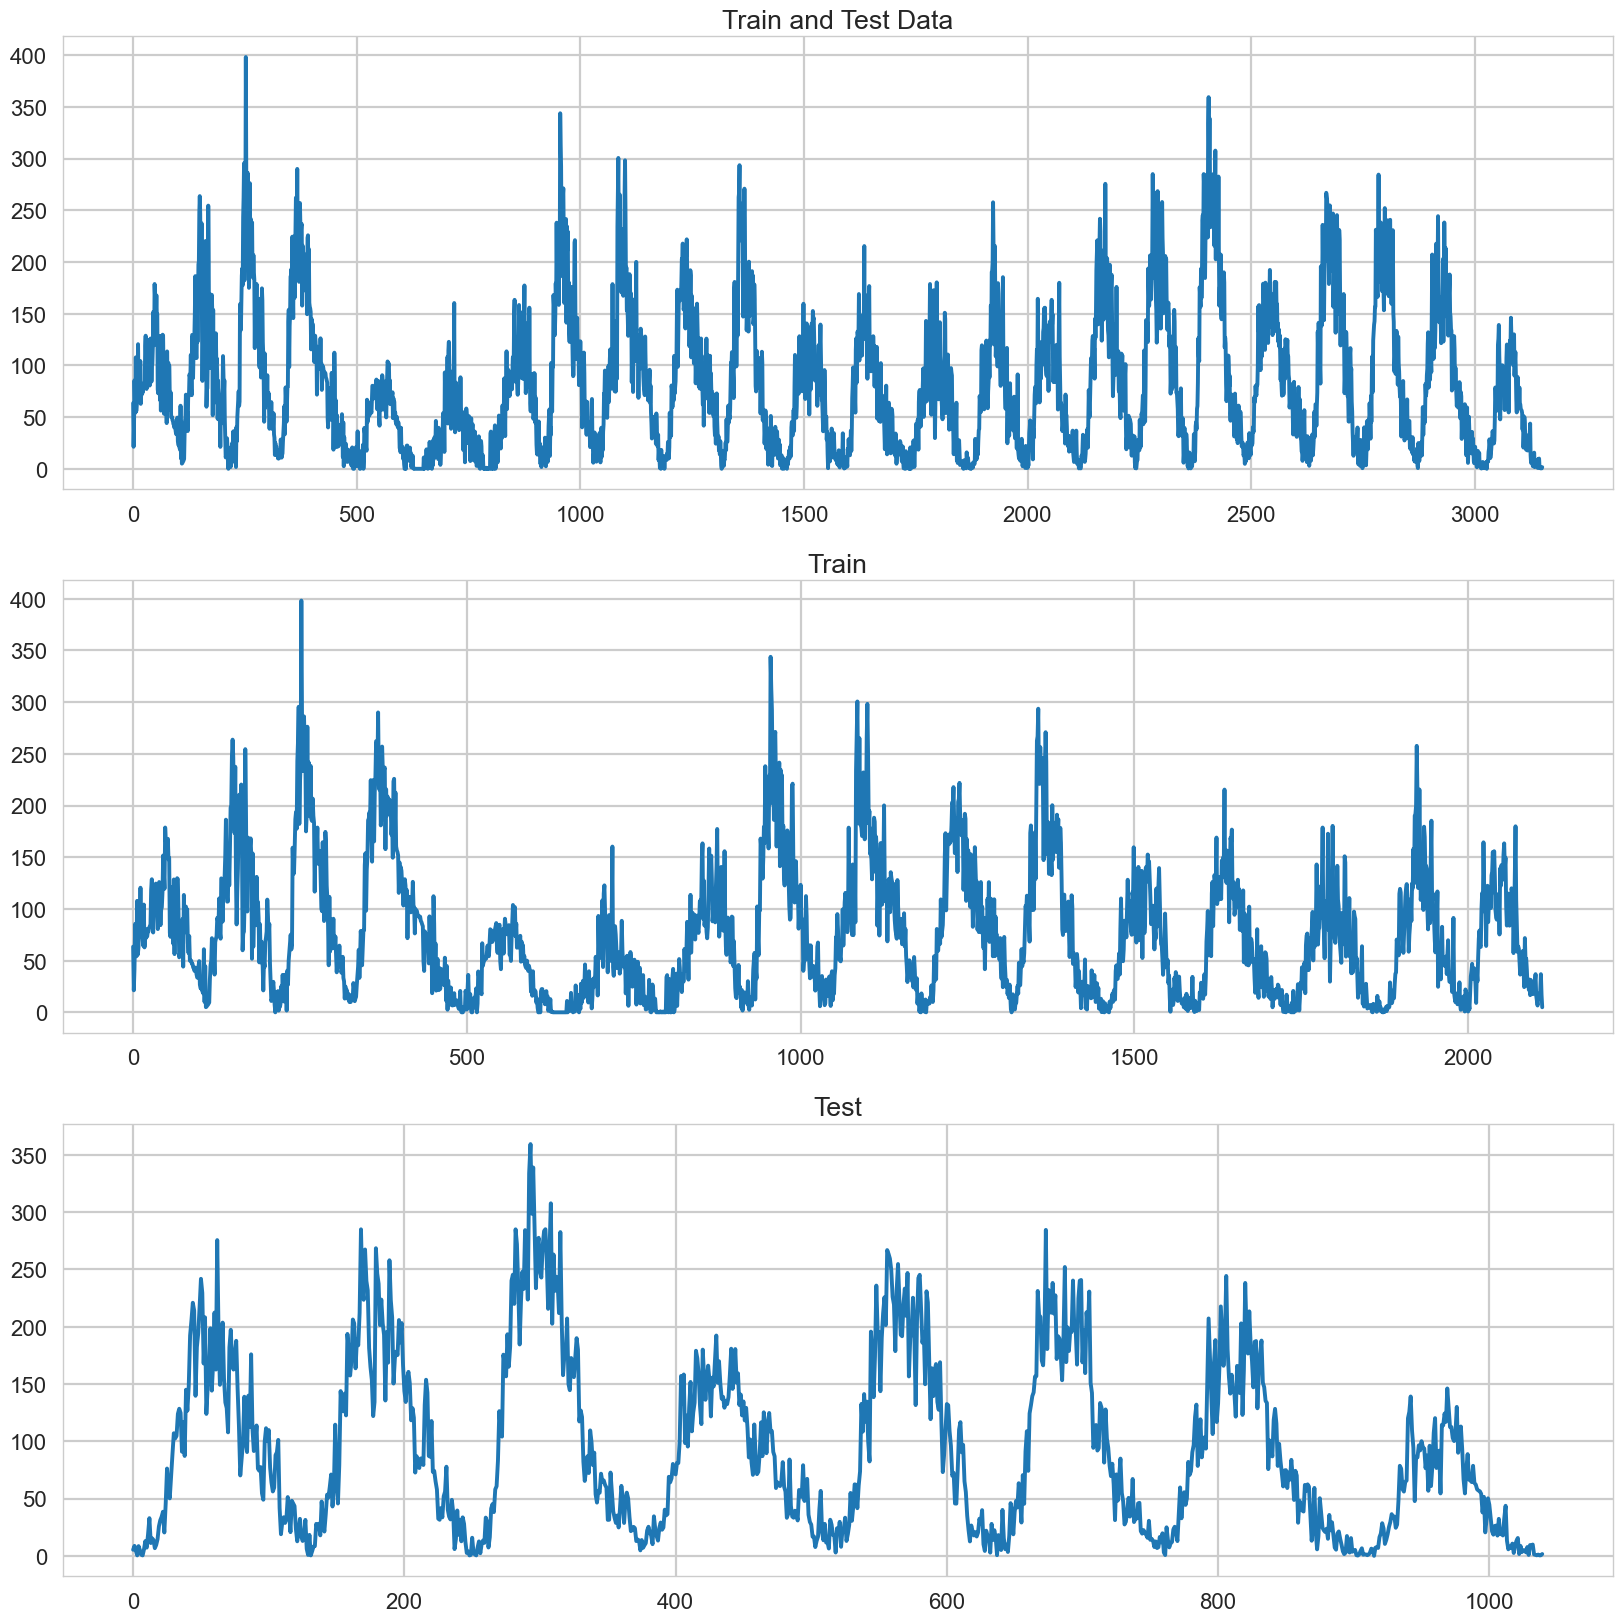

In [81]:
plt.figure(figsize=(20,20))

plt.subplot(3,1,1)
plt.plot(y);
plt.title('Train and Test Data');

plt.subplot(3,1,2)
plt.plot(y_train);
plt.title('Train');

plt.subplot(3,1,3)
plt.plot(y_test);
plt.title('Test');

### Decision Tree Regression

In [43]:
from sklearn import tree

In [44]:
model_tree1 = tree.DecisionTreeRegressor()
model_tree1.fit(X_train, y_train)

DecisionTreeRegressor()

In [45]:
y_pred_tree1 = model_tree1.predict(X_test)

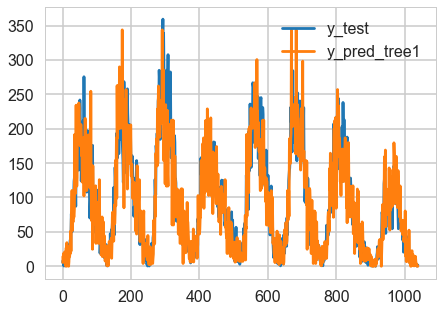

In [46]:
plt.figure(figsize=(7,5))
plt.plot(y_test, label='y_test')
plt.plot(y_pred_tree1, label='y_pred_tree1')
plt.legend();

In [66]:
mean_squared_error(y_test, y_pred_tree1)

1538.5807596153843

In [67]:
r2_score(y_test, y_pred_tree1)

0.730753750317727

### XGBoost

In [48]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [49]:
model_xgb = xgb.XGBRegressor(n_estimators=100)

In [50]:
%%time
model_xgb.fit(X_train, y_train)

Wall time: 1.11 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [51]:
y_pred = model_xgb.predict(X_test)

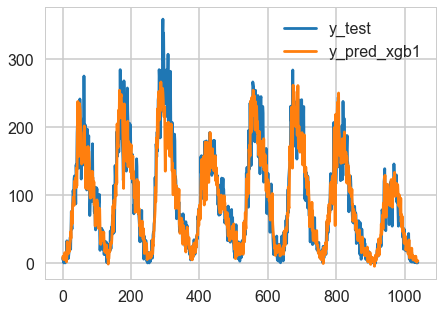

In [52]:
plt.figure(figsize=(7,5))
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred_xgb1')
plt.legend();

In [53]:
mean_squared_error(y_test, y_pred) 

840.4520882443529

In [68]:
r2_score(y_test, y_pred)

0.8529238251659962

### LightGbm

In [54]:
model_lgb1 = lgb.LGBMRegressor(n_estimators=100, objective='regression')
model_lgb1.fit(X_train, y_train)
y_pred_lgb1 = model_lgb1.predict(X_test)

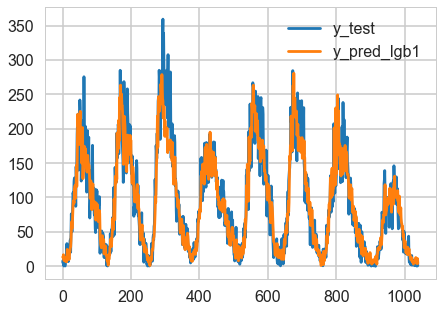

In [55]:
plt.figure(figsize=(7,5))
plt.plot(y_test, label='y_test')
plt.plot(y_pred_lgb1, label='y_pred_lgb1')
plt.legend();

In [56]:
mean_squared_error(y_test, y_pred_lgb1) 

730.6241643489424

In [69]:
r2_score(y_test, y_pred_lgb1)

0.8721433275771803

### LightGbm - Special

In [57]:
model_lgb2 = lgb.LGBMRegressor(n_estimators=100, objective='regression', linear_tree=True)

In [58]:
model_lgb2.fit(X_train, y_train)

LGBMRegressor(linear_tree=True, objective='regression')

In [59]:
y_pred_lgb2 = model_lgb2.predict(X_test)

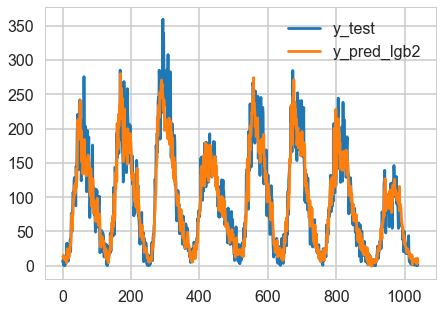

In [60]:
plt.figure(figsize=(7,5))
plt.plot(y_test, label='y_test')
plt.plot(y_pred_lgb2, label='y_pred_lgb2')
plt.legend();

In [61]:
mean_squared_error(y_test, y_pred_lgb2) 

705.8469341040623

In [70]:
r2_score(y_test, y_pred_lgb2)

0.8764792561784296

### Compare Models

In [72]:
models = ['Decision Tree', 'XGBoost', 'LightGBM', 'LightGBM-LinearTree']
scores_mse = [1538.5807596153843, 840.4520882443529, 730.6241643489424, 705.8469341040623]

df_scores = pd.DataFrame({'Model': models, 'MSE': scores_mse})
df_scores

,Model,MSE
0,Decision Tree,1538.580760
1,XGBoost,840.452088
2,LightGBM,730.624164
3,LightGBM-LinearTree,705.846934


In [73]:
import seaborn as sns

(600.0, 1600.0)

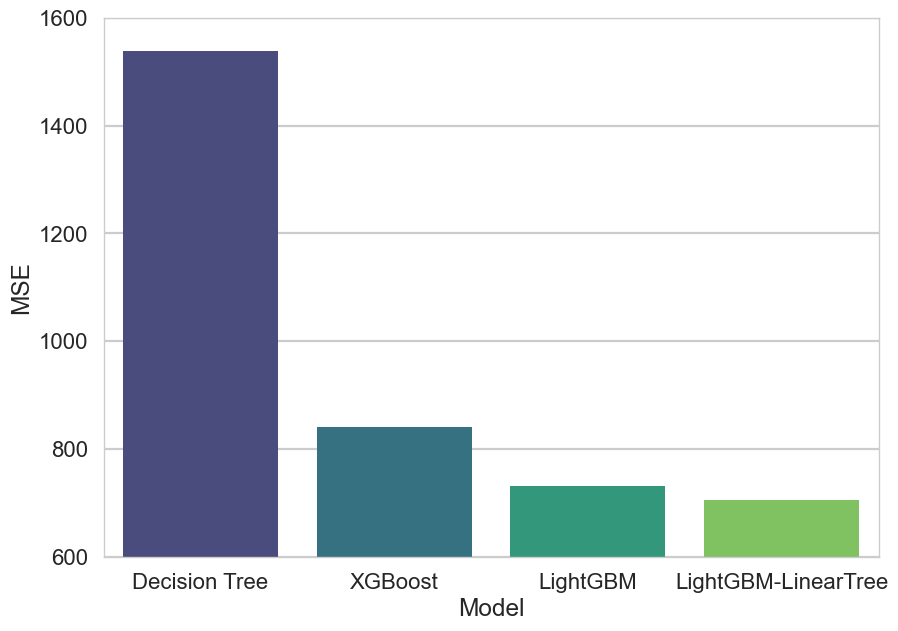

In [80]:
plt.figure(figsize=(10,7))
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
sns.barplot(x=df_scores['Model'], y=df_scores['MSE'], palette='viridis');
plt.ylim(600,1600)